In [1]:
# Standar libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os

# DPIVSoft libraries
import dpivsoft.DPIV as DPIV      #Python PIV implementation
import dpivsoft.Cl_DPIV as Cl_DPIV   #OpenCL PIV implementation
import dpivsoft.SyIm as SyIm  #Syntetic images generator

from dpivsoft.Classes  import Parameters
from dpivsoft.Classes  import grid
from dpivsoft.Classes  import GPU
from dpivsoft.Classes  import Synt_Img

%matplotlib widget

# If you need to split a movie into frame

In [ ]:
input_file='/Users/jeromenoir/polybox2/ENSEIGNEMENTS/INTRO_FLUID_DYNAMICS/EXAM/Exams_2024/Report1_BUCKET/movie1_r35.MOV'
output_dir='/Users/jeromenoir/polybox2/ENSEIGNEMENTS/INTRO_FLUID_DYNAMICS/EXAM/Exams_2024/Report1_BUCKET/movie1_r35frames'

video = cv2.VideoCapture(input_file)
ok, frame = video.read()
count = 0
while ok:
    cv2.imwrite(output_dir + "_frame%i.jpg"%count, frame)
    print('WRITTEN FRAME:',count)
    count+=1
    ok, frame = video.read()
video.release()

# Set the Directories

In [3]:

#Current path
#dirCode = os.getcwd()

dirImages = "./Example/Images/"
dirResults = "./Example/Results/"
parameterFile= "./Parameters.yaml"
extension = ".png"

if not os.path.exists(dirImages):
    print(f"Error: Input folder '{dirImages}' does not exist.")
    exit(1)
if not os.path.exists(dirResults):
    os.makedirs(dirResults)

#List of images to proccess
# files = os.listdir(dirCode + "/Example/Images/")
files = os.listdir(dirImages)
files = sorted([i for i in files if i.endswith(extension)])
print(files)

['U_Mixing_1002_1.png', 'U_Mixing_1002_2.png']


# Set PIV parameters

In [4]:
#=========================================================================================================
#SET PIV PARAMETERS
#=========================================================================================================#

#You have two options:

# 1: Load paramters from a file calling readParamters method:
Parameters.readParameters(parameterFile)

# 2: Set parameters manually (see Classes.py for more details):
Parameters.box_size_2_x = 16

starting


# CPU computing (SLOW use only if you don't have GPU)

In [10]:

#=========================================================================================================
#PYTHON PROCESSING
#=========================================================================================================
start = time.time()
#Loop for load all images (only one in the example)
for i in range(0,len(files),2):
    print(i)
    #Load images
    Img1 = np.asarray(cv2.cvtColor(cv2.imread(dirImages+files[i]),
        cv2.COLOR_BGR2GRAY)).astype(np.float32)
    Img2 = np.asarray(cv2.cvtColor(cv2.imread(dirImages+files[i+1]),
        cv2.COLOR_BGR2GRAY)).astype(np.float32)

    [height, width] = Img1.shape

    #PIV processing python
    [x2, y2, u2, v2] = DPIV.processing(Img1, Img2)
    np.savez(dirResults+'cpu_field_'+ format(int(i/2),'03d'), x=x2,  y=y2,  u=u2,  v=v2)
print("Python algorithm finished. Time = ", time.time()-start, "s")



0
Python algorithm finished. Time =  2.1075432300567627 s


# GPU computing (FAST)

In [5]:

# Select platform (only needed once). If more than one platform is installed
# use "selection"
thr = Cl_DPIV.select_Platform("selection")
os.environ['PYOPENCL_COMPILER_OUTPUT'] = '1'

# Load first pair of images to start the computation and set arrays sizes
name_img_1 = dirImages+files[0]
name_img_2 = dirImages+files[1]
Img1, Img2 = DPIV.load_images(name_img_1, name_img_2)
[height, width] = Img1.shape

# Send first pair of images to GPU
GPU.img1 = thr.to_device(Img1)
GPU.img2 = thr.to_device(Img2)

# Compile kernels and initialize variables (only needed once)
Cl_DPIV.compile_Kernels(thr)
Cl_DPIV.initialization(width, height, thr)

start = time.time()
# Loop for load all images (only one in the example)
for i in range(0,len(files),2):

    # Change the name of next iteration Images only if needed
    if i<len(files)-3:
        #Name of next iteration Images
        name_img_1 = dirImages +  files[i+2]
        name_img_2 = dirImages +  files[i+3]

    # Process images. (Next iteration Images path is send to be loaded
    # in parallel during runtime)
    Cl_DPIV.processing(name_img_1, name_img_2, thr)

    # Get final results from GPU
    x2 = GPU.x2.get()
    y2 = GPU.y2.get()
    u2 = GPU.u2_f.get()
    v2 = GPU.v2_f.get()

    # Save results in numpy file compatible with DPIVSoft format
    saveName = dirResults + 'gpu_field_' + format(int(i/2), '03d')
    DPIV.save(x2, y2, u2, v2, saveName)

print("OpenCl algorithm finished. Time = ", time.time()-start, "s")

Platform: Apple
Device: Apple M1 Pro
OpenCl algorithm finished. Time =  0.22331905364990234 s


Text(0, 0.5, 'y (pixels)')

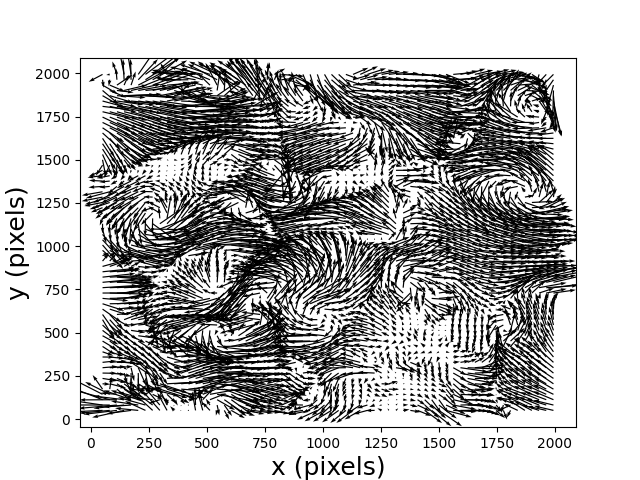

In [6]:

#===========================================================================================
#WORK WITH RESULTS
#===========================================================================================
#Load PIV results
Data = np.load(dirResults+'gpu_field_000.npz')
x = Data['x']
y = Data['y']
u = Data['u']
v = Data['v']

fig, ax1 = plt.subplots()
ax1.quiver(x, y, u, v, scale=1 / 0.03)
ax1.set_xlabel('x (pixels)',fontsize=18)
ax1.set_ylabel('y (pixels)',fontsize=18)
#plt.show()